# Reconocimiento de gustos musicales aplicado a Spotify

El objetivo del siguiente sistema de Machine Learning es obtener de forma clasificativa si a una persona le va a gustar o no una canción, utilizando como fuente de datos en este caso las listas de reproducción de uno de los integrantes del grupo.

Para poder obtener la data necesaria de Spotify, se debe utilizar la librería \textbf{Spotipy} para Python. Con Spotipy se tiene completo acceso a toda la data de la música que la plataforma de Spotify provee.

La librería se instala con los siguientes comandos:

In [4]:
!pip3 install spotipy
!pip3 install requests

## Obtención de datos

El siguiente procedimiento permite mediante las claves de autentificición solocitadas a Spotify, exportar y convertir a CSV las listas de reproduccion que se deseen.

La obtención de datos se basó en un ejemplo disponible en el siguiente link:
https://github.com/MaxHilsdorf/introduction_to_spotipy/blob/master/introduction_to_spotipy.ipynb

In [1]:
import spotipy
import spotipy.util as util
import pandas as pd

A continuación se realiza la autorización mediante la asignación de los valores de Client ID y Client Secret propios de la persona en Spotify.

In [6]:
CLIENT_ID = "3a3b9ff36d90420387079449d4edee1a" # CLIENT ID personal
CLIENT_SECRET = "6e05d04f7c2745a49acbc569fd8a2476" # CLIENT SECRET personal

Con los siguientes comandos se obtiene un \textbf{token} que otorga Spotify que le da permiso a Spotipy en python para poder accesar a los datos personales, este token se renueva cada hora. Por lo que se debe tener esto en consideración.

In [7]:
username = '12128280774'
client_id ='3a3b9ff36d90420387079449d4edee1a'
client_secret = '6e05d04f7c2745a49acbc569fd8a2476'
redirect_uri = 'http://localhost:7777/callback' #este uri se creo en el API de Spotify en el dummy app que se creo en los Developer Tools deSpotify
scope = 'user-read-recently-played'

token = util.prompt_for_user_token(username=username, 
                                   scope=scope, 
                                   client_id=client_id,   
                                   client_secret=client_secret,     
                                   redirect_uri=redirect_uri)

A continuación, desplegamos el token para verificar que se haya obtenido correctamente de Spotify.

In [13]:
print(token)

BQCPcaTM18Pa4DOji_AZNQTutZPfzmEgS58wl2VXtjtKCvAOw6jK2wVCczAGQ88Q-AJd4zatO-qSaLPyvewROLaR0IaUS7EREsSPtmOhhx2khtODqg41at0GPZomIfKUQAfy6dAEHei00vlU9GweJsp7


In [15]:
sp = spotipy.Spotify(token)

Luego, se debe encontrar el playlist que se va a descargar.

In [16]:
playlist_creator = "spotify"
playlist_id = "7Jvt5iht8f9aPWM1QWTJab"

El \textbf{playlist id} se puede encontrar cuando se abre Spotify en el navegador y se toma una sección de la URL que pertence mismo.

Ahora que tenemos identificado el playlist del cual queremos extraer información, cabe mencionar que cada canción en Spotify tiene un set de \textbf{features} que la caracterizan y son en las que se basa su algoritmo para poder caracterizar cada track.

Los mismos se van a extraer de los elementos de ese playlist y se van a ordenar en un dataset como se detalla en el siguiente código:

In [17]:
def analyze_playlist(creator, playlist_id):
    
    # Acá se crea el dataframe vacío que vendrán a ser los features de cada canción
    playlist_features_list = ["artist", "album", "track_name", "track_id", 
                             "danceability", "energy", "key", "loudness", "mode", "speechiness",
                             "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]
    playlist_df = pd.DataFrame(columns = playlist_features_list)
    
    # Se crea un diccionario(arreglo) vacío
    playlist_features = {}
    
    # Loop a travéz de cada track en el playlist, se extráen los features y se apendiczan al playlist df
    playlist = sp.user_playlist_tracks(creator, playlist_id)["items"]
    for track in playlist:
        # Obtención de metadata
        playlist_features["artist"] = track["track"]["album"]["artists"][0]["name"]
        playlist_features["album"] = track["track"]["album"]["name"]
        playlist_features["track_name"] = track["track"]["name"]
        playlist_features["track_id"] = track["track"]["id"]
        # Obtención de audio features
        audio_features = sp.audio_features(playlist_features["track_id"])[0]
        for feature in playlist_features_list[4:]:
            playlist_features[feature] = audio_features[feature]
        
        # Concatenación del dfs
        track_df = pd.DataFrame(playlist_features, index = [0])
        playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)
        
    return playlist_df

In [18]:
playlist_df = analyze_playlist(playlist_creator, playlist_id)

Luego, vamos a verificar que se han asignado valores cada una de las instancias del dataset:

In [19]:
playlist_df.head()

,artist,album,track_name,track_id,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Pete Thorn,Pete Thorn II,À l’avenir,6GhvoVU3BOpqN6bCdID8QP,0.391,0.860,7,-7.531,0,0.0573,0.849000,0.3590,0.436,90.016,211524,4
1,Porcupine Tree,Anesthetize,Fear of a Blank Planet - Live,5JS752i84FtILtqjYxJ9qK,0.454,0.832,2,-9.479,1,0.0330,0.257000,0.9540,0.440,81.001,454880,3
2,Chickenfoot,Chickenfoot,Soap On A Rope,1JFIayUYr3ziC1eUllZhKD,0.265,0.908,9,-4.316,1,0.1500,0.000589,0.5230,0.435,176.323,332120,4
3,Riverside,Shrine Of New Generation Slaves,The Depth of Self-Delusion,5zGVYRSVu3zgQczobXIX1Y,0.361,0.522,6,-9.382,0,0.0307,0.356000,0.1030,0.221,113.359,459627,4
4,The Pineapple Thief,Your Wilderness,The Final Thing on My Mind,4m3M6l513rITHvn9LaKJeA,0.357,0.497,4,-12.812,0,0.0288,0.524000,0.0675,0.116,128.864,593605,4


In [20]:
playlist_df

,artist,album,track_name,track_id,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Pete Thorn,Pete Thorn II,À l’avenir,6GhvoVU3BOpqN6bCdID8QP,0.391,0.860,7,-7.531,0,0.0573,0.849000,0.3590,0.436,90.016,211524,4
1,Porcupine Tree,Anesthetize,Fear of a Blank Planet - Live,5JS752i84FtILtqjYxJ9qK,0.454,0.832,2,-9.479,1,0.0330,0.257000,0.9540,0.440,81.001,454880,3
2,Chickenfoot,Chickenfoot,Soap On A Rope,1JFIayUYr3ziC1eUllZhKD,0.265,0.908,9,-4.316,1,0.1500,0.000589,0.5230,0.435,176.323,332120,4
3,Riverside,Shrine Of New Generation Slaves,The Depth of Self-Delusion,5zGVYRSVu3zgQczobXIX1Y,0.361,0.522,6,-9.382,0,0.0307,0.356000,0.1030,0.221,113.359,459627,4
4,The Pineapple Thief,Your Wilderness,The Final Thing on My Mind,4m3M6l513rITHvn9LaKJeA,0.357,0.497,4,-12.812,0,0.0288,0.524000,0.0675,0.116,128.864,593605,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Liquid Tension Experiment,LTE3 (Deluxe Edition),Rhapsody in Blue,323dStb7Eq9ip6yMGPOviO,0.245,0.845,4,-6.991,1,0.0752,0.605000,0.1040,0.149,109.742,796267,4
96,Liquid Tension Experiment,LTE3 (Deluxe Edition),Liquid Evolution,5LmNLowRv36pm4WfhsVrKN,0.550,0.594,11,-10.803,0,0.0372,0.786000,0.0868,0.392,138.779,202440,4
97,Liquid Tension Experiment,LTE3 (Deluxe Edition),The Passage of Time,0VqKNoxYKpZjfEGc3rVFY8,0.199,0.967,11,-6.727,0,0.0682,0.657000,0.1920,0.352,95.032,453387,4
98,Liquid Tension Experiment,LTE3 (Deluxe Edition),Beating the Odds,5b4Z6gYvOX0HgtxPjjWVyb,0.223,0.954,2,-6.490,1,0.0674,0.769000,0.1360,0.602,87.617,368720,4


In [21]:
playlist_df.to_csv("filename.csv", index = False)

Antes de continuar a la siguiente sección es importante mencionar que para poder tener datos funcionales para el proposito definido se exportaron 2 listas en formato CSV, la primera con canciones de agrado para el oyente seleccionado, y en contraste, la segunda con canciones que no lo eran. 
Además acá se define la salida como Like al valor atributivo de 1 o 0, posteriormente se ordenan aleatoriamente los datos 

## Analisis Exploratorio de Datos


A continuación una breve descripción de cada uno de los features que Spotify utiliza para identificar las canciones.

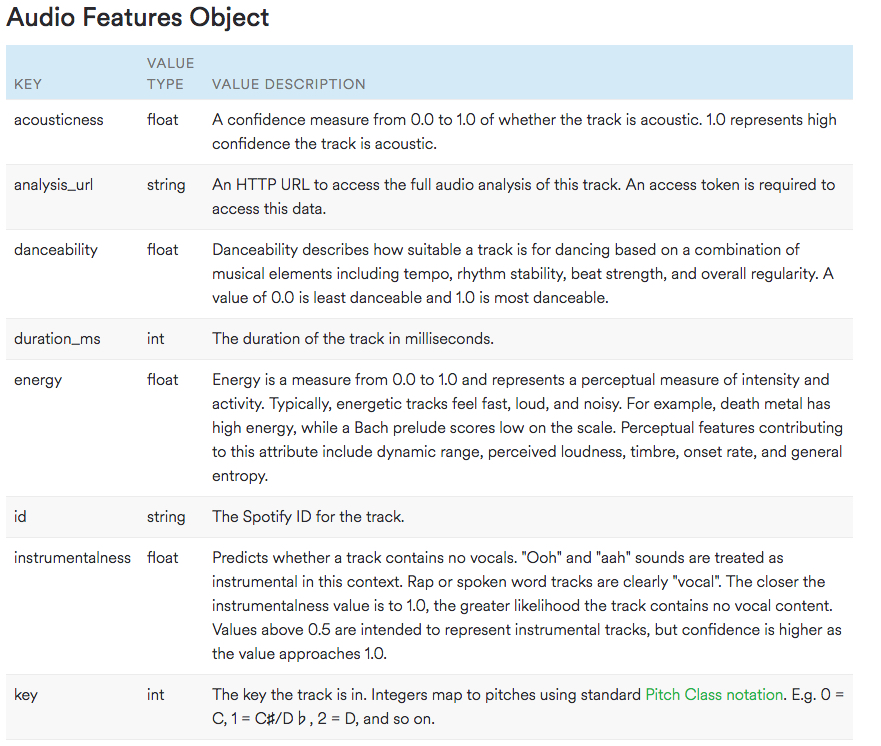

In [19]:
from IPython import display
display.Image("https://opendatascience.com/wp-content/uploads/2017/05/shot2.jpg")

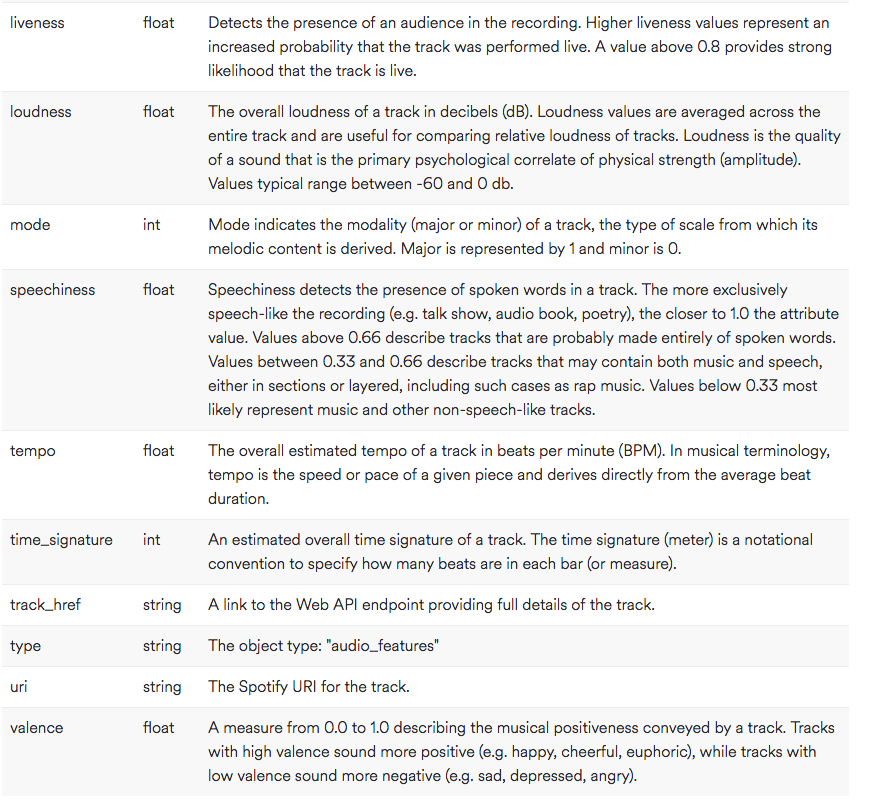

In [18]:
display.Image("https://opendatascience.com/wp-content/uploads/2017/05/shot1.jpg")

Se añaden librerias que se utilizan para graficar y realizar operaciones algebraicas 

In [6]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 

In [2]:
data = pd.read_csv("DataRolando.csv")

In [3]:
data.head()

,artist,album,track_name,track_id,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Like
0,CASIOPEA,Asian Dreamer,GALACTIC FUNK,14ls2BqFnADEaTN7amJiUi,0.610,0.851,9,-9.902,1,0.0575,0.8990,0.114,0.660,129.971,324973,4,1
1,Liquid Tension Experiment,LTE3 (Deluxe Edition),Rhapsody in Blue,323dStb7Eq9ip6yMGPOviO,0.245,0.845,4,-6.991,1,0.0752,0.6050,0.104,0.149,109.742,796267,4,1
2,Luis Enrique,Lo Que Pasó... La Historia Del Príncipe De La ...,Date un Chance,4NM6nmPnoqnQovcZ93kACn,0.505,0.608,7,-8.196,1,0.0433,0.0000,0.226,0.941,93.955,286320,4,0
3,Dream Theater,Systematic Chaos,Constant Motion,1ElUz8eHPMZitrPeAMiUng,0.242,0.969,11,-4.511,1,0.1450,0.0666,0.445,0.453,179.785,415373,4,1
4,Frank Marino & Mahogany Rush,Live (Expanded Edition),Johnny B. Goode - Live,4Neip2VZwksYYnbqmVkmea,0.219,0.966,6,-3.780,0,0.1300,0.0197,0.980,0.379,93.900,316907,4,1


Con los comandos describe y dtypes se obtiene una forma de visualizar cuales datos son categoricos, cuales son numericos y para estos ultimos algunos de sus valores estadisticos

In [5]:
data.describe()

,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Like
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.00000,200.000000
mean,0.580705,0.751040,5.170000,-6.693165,0.625000,0.069382,0.168124,0.212779,0.600194,122.662885,281884.46500,3.90000,0.500000
std,0.193017,0.183921,3.445352,2.673989,0.485338,0.047437,0.313388,0.195335,0.256328,29.324977,134165.93853,0.36146,0.501255
min,0.130000,0.168000,0.000000,-15.411000,0.000000,0.023900,0.000000,0.018100,0.032400,60.631000,75893.00000,1.00000,0.000000
25%,0.441250,0.630500,2.000000,-8.401250,0.000000,0.038275,0.000000,0.090900,0.390250,99.200250,198034.25000,4.00000,0.000000
50%,0.592500,0.788000,5.000000,-6.612000,1.000000,0.051950,0.000144,0.137000,0.624000,121.013500,251413.00000,4.00000,0.500000
75%,0.749500,0.905000,8.000000,-4.456250,1.000000,0.079275,0.094825,0.273500,0.825250,139.075500,318637.00000,4.00000,1.000000
max,0.927000,0.991000,11.000000,-0.515000,1.000000,0.273000,0.966000,0.980000,0.973000,199.978000,923693.00000,5.00000,1.000000


In [8]:
data.dtypes

artist               object
album                object
track_name           object
track_id             object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
Like                  int64
dtype: object

Como se puede observar las primeras 4 columnas corresponden a datos categoricos 

## Preprocesado de Datos

Verificando si hay missing values en el dataset

In [11]:
data.isna().sum()

artist              0
album               0
track_name          0
track_id            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
Like                0
dtype: int64

No se observan valores faltantes en ninguno de los features.

In [21]:
data.Like.value_counts()

0    100
1    100
Name: Like, dtype: int64

### Tecnica de normalizacion de los datos

Para esto se llevaran los valores de la columna deseada entre 0 y 1, esto se logra dividiendo todos los valores de la columna entre el máximo encontrado, notese que para esto es importante haber realizado previamente la eliminiación de outliers, en caso contrario no se obtendran datos coherentes


El feature 'key' es de tipo categorico(esto se observó reanalizando la data) por lo tanto se trabajará en el formato One Hot Encoding

In [22]:
data=pd.get_dummies(data, columns=['key']) 

In [3]:
#max_key=data['key'].max()
#data['key']=data['key']/max_key


In [7]:
data['tempo']=data['tempo']/data['tempo'].max()

In [9]:
data['duration_ms']=data['duration_ms']/data['duration_ms'].max()

Nota el parametro 'loudness' conlleva más trabajo para normalizar dado que expresion es logaritmica y corresponde a los decibeles.


$$
\beta= 10log\dfrac{I}
{I_0} $$ 

Donde beta es la intensidad en db,I es la intensidad en Watts metro cuadrado e Io es la intensidad del umbral de audicion 


In [11]:
Watts_loudness=((data['loudness']/10)-12)

In [12]:
Watts_loudness=pow(10,Watts_loudness)

In [13]:
data['loudness']=Watts_loudness/Watts_loudness.max()

Notese como ahora los valores estan entre 0 y 1, para esto visualicemos nuevamente el encabezado

In [23]:
data.head()

,artist,album,track_name,track_id,danceability,energy,loudness,mode,speechiness,instrumentalness,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
0,CASIOPEA,Asian Dreamer,GALACTIC FUNK,14ls2BqFnADEaTN7amJiUi,0.610,0.851,0.115160,1,0.0575,0.8990,...,0,0,0,0,0,0,0,1,0,0
1,Liquid Tension Experiment,LTE3 (Deluxe Edition),Rhapsody in Blue,323dStb7Eq9ip6yMGPOviO,0.245,0.845,0.225113,1,0.0752,0.6050,...,0,0,1,0,0,0,0,0,0,0
2,Luis Enrique,Lo Que Pasó... La Historia Del Príncipe De La ...,Date un Chance,4NM6nmPnoqnQovcZ93kACn,0.505,0.608,0.170569,1,0.0433,0.0000,...,0,0,0,0,0,1,0,0,0,0
3,Dream Theater,Systematic Chaos,Constant Motion,1ElUz8eHPMZitrPeAMiUng,0.242,0.969,0.398474,1,0.1450,0.0666,...,0,0,0,0,0,0,0,0,0,1
4,Frank Marino & Mahogany Rush,Live (Expanded Edition),Johnny B. Goode - Live,4Neip2VZwksYYnbqmVkmea,0.219,0.966,0.471520,0,0.1300,0.0197,...,0,0,0,0,1,0,0,0,0,0


A continuación, por medio de la siguiente instrucción, realizamos una correlación entre los datos

In [24]:
data.corr()

,danceability,energy,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
danceability,1.000000,-0.151259,0.118642,0.078472,0.078003,-0.378166,-0.219469,0.661314,0.012642,-0.438634,...,-0.020441,0.110184,-0.105978,0.085353,-0.053785,0.044030,0.058233,-0.016112,0.085674,-0.073967
energy,-0.151259,1.000000,0.382471,-0.037661,0.259457,0.190458,0.123854,-0.041853,0.066921,0.211298,...,0.095471,-0.018731,-0.037743,-0.144422,0.067527,0.018651,0.076314,0.029323,-0.014098,0.026475
loudness,0.118642,0.382471,1.000000,0.058959,0.203377,-0.265935,0.005390,0.168226,0.012568,-0.251508,...,-0.033922,-0.011553,-0.005906,-0.064036,-0.019191,-0.012651,0.081394,0.029971,0.165080,-0.061283
mode,0.078472,-0.037661,0.058959,1.000000,0.017437,-0.097699,0.072690,0.038169,0.068814,-0.191091,...,0.189063,-0.105951,-0.238120,-0.108721,-0.080958,0.206302,0.212512,-0.150328,-0.045408,-0.172813
speechiness,0.078003,0.259457,0.203377,0.017437,1.000000,-0.084773,0.000210,0.042988,0.118260,-0.024854,...,0.155840,0.015489,-0.143319,-0.108828,-0.024284,-0.027427,-0.024126,0.049610,0.083688,-0.017776
instrumentalness,-0.378166,0.190458,-0.265935,-0.097699,-0.084773,1.000000,-0.065422,-0.382523,-0.053600,0.334630,...,0.104252,-0.055842,0.050860,-0.135854,-0.020433,0.031246,-0.123591,0.106510,-0.089143,0.122304
liveness,-0.219469,0.123854,0.005390,0.072690,0.000210,-0.065422,1.000000,-0.211029,0.005200,0.101205,...,0.162923,-0.063914,0.044143,-0.116876,0.079605,-0.038846,-0.119474,-0.039509,0.126183,0.099185
valence,0.661314,-0.041853,0.168226,0.038169,0.042988,-0.382523,-0.211029,1.000000,0.011283,-0.393314,...,-0.028996,0.073577,-0.170698,0.115005,-0.104306,0.054482,0.123034,-0.123975,0.134448,-0.002818
tempo,0.012642,0.066921,0.012568,0.068814,0.118260,-0.053600,0.005200,0.011283,1.000000,-0.021366,...,0.048377,-0.056508,-0.015355,-0.005596,-0.042509,-0.042956,0.046222,0.073675,-0.078661,-0.029321
duration_ms,-0.438634,0.211298,-0.251508,-0.191091,-0.024854,0.334630,0.101205,-0.393314,-0.021366,1.000000,...,0.034917,-0.077462,0.209249,-0.114915,0.006533,-0.100543,-0.092937,0.077590,-0.081823,0.039107


Como es de esperarse, la diagonal central es 1 dado que se compara cada entrada consigo misma.

Si nos enfocamos en la salida, que en nuestro caso es la columna 'Like', se puede observar por ejemplo con el feature 'danceability' tiene una alta correlación negativa, lo que indica una relación inversamente proporcional, es decir, a medida que incrementa dicho atributo en una canción, disminuye la probabilidad de que sea de agrado para el individuo en estudio.  De manera contraria, se observa un valor relativamente alto del feature instrumentalness.

In [4]:
import seaborn as sns

La siguiente gráfica muestra el como la data esta distribuida equitativamente en muestras de Like y Dont Like.

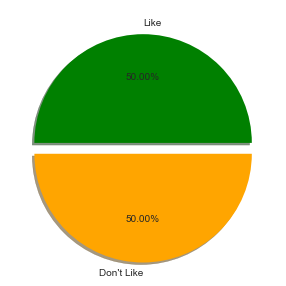

In [26]:
plt.style.use("seaborn")
fig, ax = plt.subplots(figsize=(5,5))

plt.pie(x=data["Like"].value_counts(), 
        colors=["green","orange"], 
        labels=["Like", "Don't Like"],
        shadow = True, 
        explode = (0, 0.1),
        autopct="%1.2f%%", 
        )
plt.show()

A continuación se despliegan histogramas comparativos de varios features, en los que se utiliza la salida 'Like' como punto comparativo:

El método para desplegar los datos se obtuvo en el siguiente link:
https://www.kaggle.com/sungwoon03/spotify-song-attributes-analysis

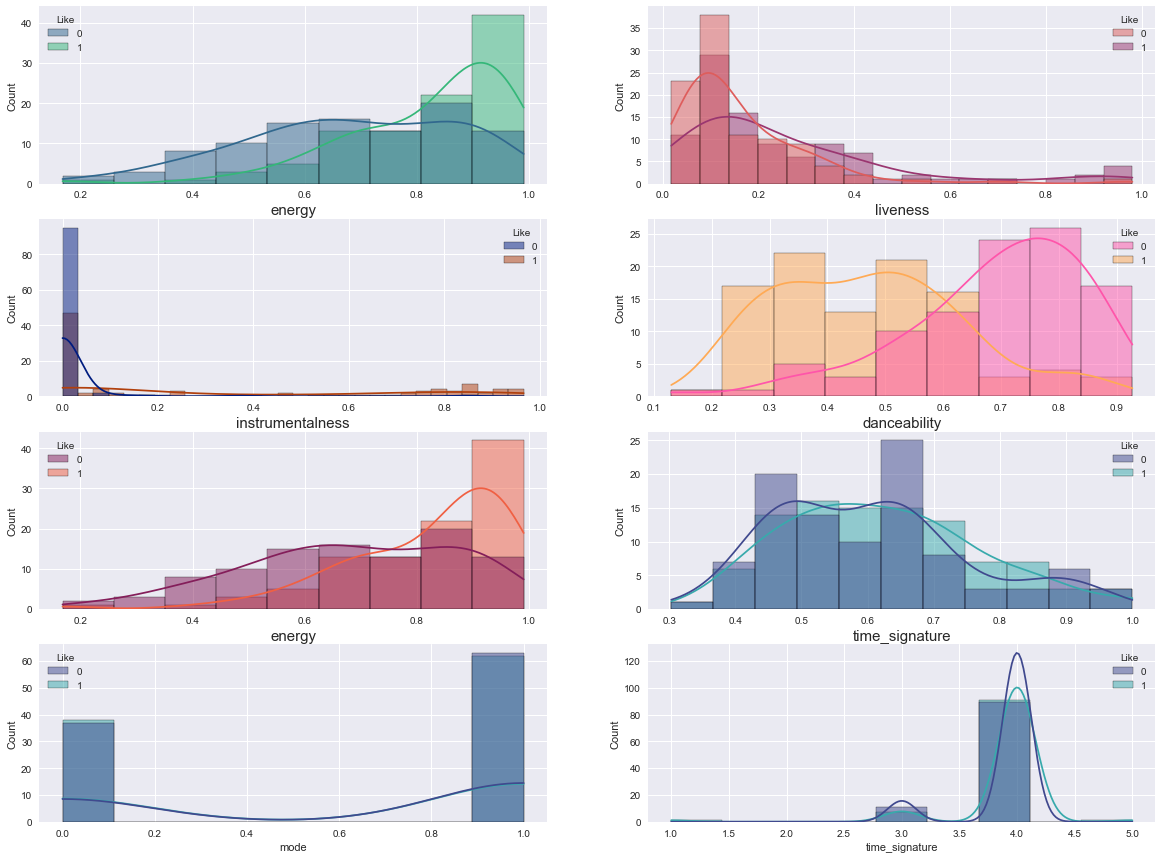

In [21]:
plt.style.use("seaborn")
fig, ax =plt.subplots(4,2, figsize=(20,15)) 


sns.histplot(x = data["energy"], hue = data["Like"], kde=True, ax=ax[0,0], palette="viridis");
ax[0,0].set_xlabel("energy",fontsize=15);

sns.histplot(x = data["liveness"], hue = data["Like"], kde=True, ax=ax[0,1], palette="flare");
ax[0,1].set_xlabel("liveness",fontsize=15);

sns.histplot(x = data["instrumentalness"], hue = data["Like"], kde=True, ax=ax[1,0], palette="dark");
ax[1,0].set_xlabel("instrumentalness",fontsize=15);

sns.histplot(x = data["danceability"], hue = data["Like"], kde=True, ax=ax[1,1], palette="spring");
ax[1,1].set_xlabel("danceability",fontsize=15);

sns.histplot(x = data["energy"], hue = data["Like"], kde=True, ax=ax[2,0], palette="rocket");
ax[2,0].set_xlabel("energy",fontsize=15);

sns.histplot(x = data["tempo"], hue = data["Like"], kde=True, ax=ax[2,1], palette="mako");
ax[2,1].set_xlabel("tempo",fontsize=15);

sns.histplot(x = data["mode"], hue = data["Like"], kde=True, ax=ax[3,0], palette="mako");
ax[2,1].set_xlabel("mode",fontsize=15);


sns.histplot(x = data["time_signature"], hue = data["Like"], kde=True, ax=ax[3,1], palette="mako");
ax[2,1].set_xlabel("time_signature",fontsize=15);



Al observar las correlaciones y las gráficas, se puede determinar que el feature 'time_signature' no aporta mucho al dataset.

Por medio de la siguiente instrucción y al observar el dataset con el que se cuenta, se decide disponer de varias de las columnas que no aportarían data valiosa para el propósito de este análisis. Ya que lo que utiliza el algoritmo de Spotify para realizar comparaciones y sugerencias son las variaciones en los features que son de caracter numérico. Entiéndase como \textbf{danceability}, \textbf{energy}, \textbf{key}, \textbf{loudness}, \textbf{speechiness}, \textbf{instrumentalness}, \textbf{liveness}, \textbf{valence}, \textbf{tempo} y \textbf{duration_ms}. 

De esta manera, se tiene un dataset con el que se puede comenzar a trabajar y a realizar pruebas de test y entrenamiento.

In [25]:
features = data.drop(['Like', 'time_signature','track_id','track_name','album','artist'],axis=1)
label = data['Like']

In [26]:
features
#visualización de los features después de normalización de datos y disposición de columnas no necesarias

,danceability,energy,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
0,0.610,0.851,0.115160,1,0.0575,0.899000,0.1140,0.660,0.649926,0.351819,...,0,0,0,0,0,0,0,1,0,0
1,0.245,0.845,0.225113,1,0.0752,0.605000,0.1040,0.149,0.548770,0.862047,...,0,0,1,0,0,0,0,0,0,0
2,0.505,0.608,0.170569,1,0.0433,0.000000,0.2260,0.941,0.469827,0.309973,...,0,0,0,0,0,1,0,0,0,0
3,0.242,0.969,0.398474,1,0.1450,0.066600,0.4450,0.453,0.899024,0.449687,...,0,0,0,0,0,0,0,0,0,1
4,0.219,0.966,0.471520,0,0.1300,0.019700,0.9800,0.379,0.469552,0.343087,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.576,0.682,0.226569,1,0.0296,0.000091,0.0804,0.230,0.424977,0.315112,...,0,0,0,0,0,0,0,1,0,0
196,0.876,0.520,0.101812,0,0.0482,0.000000,0.0925,0.961,0.484888,0.182138,...,0,0,0,1,0,0,0,0,0,0
197,0.666,0.936,0.114710,1,0.0476,0.086000,0.1530,0.776,0.457935,0.306278,...,0,0,0,0,0,1,0,0,0,0
198,0.667,0.873,0.150107,0,0.0469,0.000002,0.0338,0.920,0.937308,0.272009,...,0,0,0,1,0,0,0,0,0,0


In [27]:
label

0      1
1      1
2      0
3      1
4      1
      ..
195    1
196    0
197    1
198    0
199    0
Name: Like, Length: 200, dtype: int64

## Aprendizaje Supervisado

A partir de este momento se comienza a realizar tests de modelos:

In [28]:
from sklearn.model_selection import train_test_split

In [29]:

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

In [30]:
from sklearn.naive_bayes import GaussianNB
nbg = GaussianNB().fit(X_train, y_train)
print("Training set score: {:.3f}".format(nbg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(nbg.score(X_test, y_test)))

Training set score: 0.844
Test set score: 0.750


In [31]:
from sklearn.naive_bayes import MultinomialNB
nbm = MultinomialNB(alpha=1).fit(X_train, y_train)
print("Training set score: {:.3f}".format(nbm.score(X_train, y_train)))
print("Test set score: {:.3f}".format(nbm.score(X_test, y_test)))


Training set score: 0.781
Test set score: 0.675


In [32]:
from sklearn.svm import SVC

svc = SVC(gamma='auto')
svc.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 0.88
Accuracy on test set: 0.88


In [33]:
from sklearn.svm import SVC

svc = SVC(gamma='scale')
svc.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 0.92
Accuracy on test set: 0.93


In [34]:

from sklearn.svm import SVC

svc = SVC(gamma='scale',kernel='sigmoid')
svc.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))


Accuracy on training set: 0.88
Accuracy on test set: 0.93


In [35]:
from sklearn.svm import SVC

svc = SVC(gamma='scale',kernel='poly')
svc.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 0.93
Accuracy on test set: 0.93


In [36]:

from sklearn.svm import SVC

svc = SVC(gamma='scale',kernel='poly', degree=8)
svc.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 0.96
Accuracy on test set: 0.82


In [37]:
from sklearn.svm import SVC

svc = SVC(gamma='scale',kernel='poly', degree=2)
svc.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 0.93
Accuracy on test set: 0.93


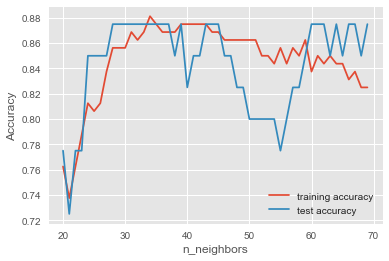

In [54]:
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier 
training_accuracy = []
test_accuracy = [] 
plt.style.use('ggplot')
%matplotlib inline

neighbors_settings = range(20, 70)
for n_neighbors in neighbors_settings:
    # se construye el modelo de clasificacion
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # se almacena el "training set accuracy"
    training_accuracy.append(clf.score(X_train, y_train))
    # se almacena la "generalization accuracy"
    test_accuracy.append(clf.score(X_test, y_test))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [55]:
# se construye el modelo de clasificacion
clf = KNeighborsClassifier(n_neighbors=34)
clf.fit(X_train, y_train)
print("Training set score:")
print(clf.score(X_train, y_train))
print("Test set score:")
print(clf.score(X_test, y_test))

Training set score:
0.88125
Test set score:
0.875


In [40]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
clf = AdaBoostClassifier()
clf.fit(X_train, y_train) 
print("Training set score:")
print(clf.score(X_train, y_train))
print("Test set score:")
print(clf.score(X_test, y_test))

Training set score:
0.99375
Test set score:
0.875


In [41]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
clf = AdaBoostClassifier(n_estimators=20, random_state=None, algorithm='SAMME')
clf.fit(X_train, y_train) 
print("Training set score:")
print(clf.score(X_train, y_train))
print("Test set score:")
print(clf.score(X_test, y_test))

Training set score:
0.9
Test set score:
0.85


In [42]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
clf = AdaBoostClassifier(n_estimators=18, random_state=None, algorithm='SAMME.R')
clf.fit(X_train, y_train) 
print("Training set score:")
print(clf.score(X_train, y_train))
print("Test set score:")
print(clf.score(X_test, y_test))

Training set score:
0.95
Test set score:
0.925


In [48]:

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import tree
#export_graphviz(DecisionTreeModel, out_file='simple_tree.dot', feature_names=features.columns,impurity=False,class_names=['Dislike','Like'],filled=True)
from subprocess import call

In [46]:
DecisionTreeModel = DecisionTreeClassifier(max_depth = 9)
DecisionTreeModel.fit(X_train,y_train)
y_predict = DecisionTreeModel.predict(X_test)
dt3 = accuracy_score(y_test, y_predict)
dt3

0.875

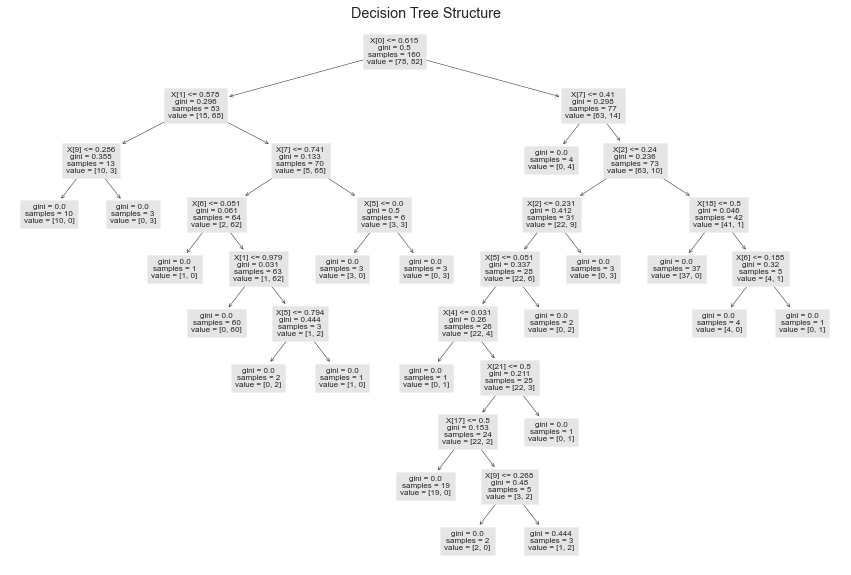

In [47]:
plt.figure(figsize=(15,10))
tree.plot_tree(DecisionTreeModel, fontsize=8)
plt.title("Decision Tree Structure")
plt.show()